In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import re

DATA_PATH = '../data/merged.pickle'

In [2]:
import cPickle as pickle

with open(DATA_PATH, 'r') as f:
    data = pickle.load(f)

labels = np.load('../data/labels.npy')

In [3]:
non_zero_lumi_index = np.where(
    (data['_instantLumi_minibias'] != 0.0) | \
    (data['_instantLumi_muons'] != 0.0) | \
    (data['_instantLumi_photons'] != 0.0)
)[0]

In [4]:
def rename_features(feature):
    return feature.replace('n_events', 'events').replace('non_zeros_weights', 'nonzeros')

In [5]:
not_features = [
    '_luminosityBlock',
    '_run',
    '_instantLumi_minibias',
    '_instantLumi_muons',
    '_instantLumi_photons'
]

features = sorted(set(data.columns) - set(not_features))

print [
    f
    for f in features
    if 'zeros' in f
]

X = data[features].iloc[non_zero_lumi_index]
y = labels[non_zero_lumi_index]
weights = data['_instantLumi_minibias'].values[non_zero_lumi_index]

features = [ rename_features(f) for f in features ]

X.columns = features

['minibias_non_zeros_weights', 'muons_non_zeros_weights', 'photons_non_zeros_weights']


In [6]:
print 'Non-zero luminosity:', non_zero_lumi_index.shape[0], 'lumisections'

Non-zero luminosity: 26046 lumisections


In [7]:
### utility functions
def insert(keys, d, f):
    key = keys[0]

    if len(keys) == 1:
        d[key] = f
    else:
        if not d.has_key(key):
            d[key] = dict()
        return insert(keys[1:], d[key], f)

def levels(features, n_levels = 5):
    dicts = [features]

    levels = list()

    for level in range(n_levels):
        levels.append(
            set([ k for d in dicts for k in d ])
        )
    
        dicts = [ d[k] for d in dicts for k in d ]
    return levels
    
def get_feature_groups(feature_list, re_exp):
    """
    Retuns:
    1. hierachical dictionary feature groups -> feature full name
    2. feature levels
    3. unprocessed features
        
    """
    features = dict()
    rest = list()
    n_levels = set()

    for f in feature_list:
        matches = re.findall(re_exp, f)

        if len(matches) == 1:
            insert(matches[0], features, f)
            n_levels.add(len(matches[0]))
        elif len(matches) == 0:
            rest.append(f)
        else:
            raise Exception('Very suspicious feature: %s -> %s' % (f, matches))
    assert len(n_levels) == 1
    return features, levels(features, n_levels=list(n_levels)[0]), rest

In [8]:
def insert_fake_path(d, level, path = 'general'):
    if level == 0:
        return { path : d }
    else:
        r = dict()
        for k in d:
            r[k] = insert_fake_path(d[k], level - 1, path)
        
        return r

In [9]:
particle_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(q[12345])[_](\w+)')
particle_features, particle_levels, rest = get_feature_groups(features, particle_f_re)

In [10]:
for level in particle_levels:
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
phi pt fX fY fZ eta mass
q1 q3 q2 q5 q4
std p99 p1 p25 p75 p50 mean


In [11]:
particle_type_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+([a-zA-Z0-9]+)')
particle_type_features, particle_type_levels, rest = get_feature_groups(rest, particle_type_f_re)

In [12]:
particle_type_features = insert_fake_path(particle_type_features, level = 2, path='allParticles')

for level in levels(particle_type_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
allParticles
Pz Px Py
std p99 p1 p25 p75 p50 mean


In [13]:
event_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(\w+)')
event_features, event_levels, rest = get_feature_groups(rest, event_f_re)

In [14]:
for level in event_levels:
    print ' '.join(list(level))

muons minibias photons
instantLumi
std p99 p1 p25 p75 p50 mean


In [15]:
f = insert_fake_path(event_features, level = 1, path='allChannels')
f = insert_fake_path(f, level = 2, path='allParticles')

event_features = f

for level in levels(event_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
allChannels
allParticles
instantLumi
std p99 p1 p25 p75 p50 mean


In [16]:
stream_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)')
stream_features, stream_levels, rest = get_feature_groups(rest, stream_f_re)

In [17]:
for level in stream_levels:
    print ' '.join(list(level))

muons minibias photons
events nonzeros


In [18]:
def flatten(a_dict):
    for k in a_dict:
        if hasattr(a_dict[k], 'keys'):
            for path, value in flatten(a_dict[k]):
                yield (k, ) + path, value
        else:
            yield (k, ), a_dict[k]

def merge(dicts):
    result = dict()
    for d in dicts:
        for path, value in flatten(d):
            insert(path, result, value)

    return result

def flatten_dict(d):
    r = dict()
    for paths, v in flatten(d):
        k = '_'.join(paths)
        r[k] = v
    return r

def squezze(d, depth = 5, last=2):
    if depth - 1 == last:
        for k in d:
            d[k] = flatten_dict(d[k])
        
        return d
    else:
        for k in d:
            d[k] = squezze(d[k], depth-1, last)
        
        return d

In [19]:
feature_hierarchy = merge([
    particle_features, particle_type_features, event_features
])

In [20]:
def get_levels(tree):
    if hasattr(tree, 'keys'):
        return set([1 + level for k in tree for level in get_levels(tree[k])])
    else:
        return set([0])

def cut_tree(tree, level=2):
    subtrees = list()

    for k in tree:
        levels = list(get_levels(tree[k]))
        if len(levels) == 1 and levels[0] == level:
            return [ (k, tree[k]) for k in tree ]
        else:
            return [ subtree for k in tree for subtree in cut_tree(tree[k], level)]

In [21]:
def feature_groups(subtrees):
    groups = []
    for name, subtree in subtrees:
        for channel in subtree:
            groups.append(subtree[channel].values())
    
    return groups

In [22]:
levels(feature_hierarchy, n_levels=5)

[{u'minibias', u'muons', u'photons'},
 {u'PF', 'allChannels', u'calo', u'muons', u'photons'},
 {'allParticles', u'eta', u'fX', u'fY', u'fZ', u'mass', u'phi', u'pt'},
 {u'Px', u'Py', u'Pz', u'instantLumi', u'q1', u'q2', u'q3', u'q4', u'q5'},
 {u'mean', u'p1', u'p25', u'p50', u'p75', u'p99', u'std'}]

In [23]:
feature_groups = [
    ('%s_%s' % (channel, k), d.values())
    for channel, subtree in cut_tree(squezze(feature_hierarchy, depth=5, last=3), level=2)
    for k, d in subtree.items()
] + [
    ('stream_features', flatten_dict(stream_features).values())
]

In [24]:
flatten_dict(stream_features)

{'minibias_events': 'minibias_events',
 'minibias_nonzeros': 'minibias_nonzeros',
 'muons_events': 'muons_events',
 'muons_nonzeros': 'muons_nonzeros',
 'photons_events': 'photons_events',
 'photons_nonzeros': 'photons_nonzeros'}

### Normalization

In [25]:
for col in X.columns:
    c = X[col].values
    
    mean = np.mean(c)
    std = np.std(c)
    
    if std > 1.0e-32:
        X[col] = (c - mean) / std

assert np.all(np.isfinite(X.values))

## Feature groups

In [26]:
[ (k, len(v)) for k, v in feature_groups]

[(u'muons_muons', 266),
 (u'muons_photons', 231),
 (u'muons_PF', 126),
 (u'muons_allChannels', 7),
 (u'muons_calo', 266),
 (u'minibias_muons', 266),
 (u'minibias_photons', 231),
 (u'minibias_PF', 126),
 (u'minibias_allChannels', 7),
 (u'minibias_calo', 266),
 (u'photons_muons', 266),
 (u'photons_photons', 231),
 (u'photons_PF', 126),
 (u'photons_allChannels', 7),
 (u'photons_calo', 266),
 ('stream_features', 6)]

In [27]:
fgroups = [ v for k, v in feature_groups ]

## Independent fit

In [28]:
from rep.utils import train_test_split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, train_size=0.2)

In [29]:
class StackedClassifier(object):
    def __init__(self, base_clf_factory, meta_clf, feature_groups, cv=10, checks=5):
        self.base_clf_factory = base_clf_factory
        self.base_clfs = []
        self.meta_clf = meta_clf
        
        self.feature_groups = feature_groups
        self.cv = cv
        self.checks = checks
        
    def fit_base_clfs(self, X, y, w):
        self.base_clfs = []

        for group in self.feature_groups:
            clf = self.base_clf_factory(len(group))
            
            clf.fit(X[group], y, w)

            self.base_clfs.append(clf)
    
    def predict_base_clfs(self, X):
        scores = []

        for clf, group in zip(self.base_clfs, self.feature_groups):
            scores.append(
                clf.predict_proba(X[group])[:, 1]
            )
        
        return np.vstack(scores).T.astype('float64')
        
    def fit(self, X, y, sample_weights):
        from sklearn.cross_validation import StratifiedKFold
        from itertools import islice
        
        kfold = StratifiedKFold(y, n_folds=self.cv, shuffle=True)
        
        meta_scores = []
        meta_labels = []
        meta_weights = []

        for train_ind, test_ind in islice(kfold, self.checks):
            X_train = X.iloc[train_ind]
            X_test = X.iloc[test_ind]
            
            self.fit_base_clfs(X_train, y[train_ind], sample_weights[train_ind])
            scores = self.predict_base_clfs(X_test)
            
            meta_scores.append(scores)
            
            meta_labels.append(y[test_ind])
            meta_weights.append(sample_weights[test_ind])
        
        meta_labels = np.hstack(meta_labels)
        meta_scores = np.vstack(meta_scores)
        meta_weights = np.hstack(meta_weights)
        
        self.meta_clf.fit(meta_scores, meta_labels, meta_weights)
        self.fit_base_clfs(X, y, sample_weights)
        
        return self
    
    def predict_proba(self, X):
        scores = self.predict_base_clfs(X)
        return self.meta_clf.predict_proba(scores)

In [30]:
from rep.estimators import XGBoostClassifier
from sklearn.ensemble import RandomForestClassifier

base_clf = lambda fgroup: RandomForestClassifier(
    n_estimators=32,
    max_depth=7,
    n_jobs=-1
)

meta_clf = XGBoostClassifier(
    n_estimators=32,
    max_depth = 4,
    eta=0.2,
    nthreads=32
)

stacked_rf_xgb_clf = StackedClassifier(base_clf, meta_clf, fgroups, cv=10, checks=5)

In [31]:
%%time

stacked_rf_xgb_clf.fit(X_train, y_train, w_train)
stacked_rf_xgb_proba = stacked_rf_xgb_clf.predict_proba(X_test)[:, 1].astype('float64')

CPU times: user 1min 9s, sys: 3.68 s, total: 1min 13s
Wall time: 36.2 s


In [32]:
from rep.estimators import XGBoostClassifier
from sklearn.ensemble import RandomForestClassifier

base_clf = lambda fgroup: XGBoostClassifier(
    n_estimators=32, max_depth=6, eta=0.3, nthreads=32
)

meta_clf = XGBoostClassifier(
    n_estimators=32,
    max_depth = 4,
    eta=0.2,
    nthreads=32
)

stacked_double_xgb_clf = StackedClassifier(base_clf, meta_clf, fgroups, cv=10, checks=5)

In [33]:
%%time

stacked_double_xgb_clf.fit(X_train, y_train, w_train)
stacked_double_xgb_proba = stacked_double_xgb_clf.predict_proba(X_test)[:, 1].astype('float64')

CPU times: user 43min 5s, sys: 17.7 s, total: 43min 22s
Wall time: 1min 45s


In [34]:
%%time

from rep.estimators import XGBoostClassifier

xgb_clf = XGBoostClassifier(
    n_estimators=64,
    max_depth=6,
    eta=0.3,
    nthreads=32
)

xgb_clf.fit(X_train, y_train, w_train)
xgb_proba = xgb_clf.predict_proba(X_test)[:, 1].astype('float64')

CPU times: user 5min 53s, sys: 3.38 s, total: 5min 56s
Wall time: 19.4 s


In [35]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=128,
    max_depth=8,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train, w_train)
rf_proba = rf_clf.predict_proba(X_test)[:, 1].astype('float64')

CPU times: user 15.8 s, sys: 473 ms, total: 16.2 s
Wall time: 1.59 s


## AdaBoost

In [36]:
class AdaChain(object):
    def __init__(self,
                 base_clf_factory,
                 feature_groups,
                 max_learning_rate = 1.0,
                 n_chains = 2):
        self.base_clf_factory = base_clf_factory
        self.chains = []
        self.coefs = np.zeros(shape=(n_chains, len(feature_groups)))
        
        self.feature_groups = feature_groups
        self.n_chains = n_chains
        self.max_learning_rate = max_learning_rate
        
    def fit(self, X, y, sample_weights):
        from scipy.optimize import minimize_scalar

        chain_score = 0.5

        for chain_i in xrange(self.n_chains):
            chain = []
            print 'Fitting %d chain' % chain_i

            for fgi, fgroup in enumerate(self.feature_groups):
                target_w = np.exp(-(2 * y - 1) * (2 * chain_score - 1))

                clf = self.base_clf_factory(fgroup)

                clf.fit(X[fgroup], y, sample_weights * target_w)

                proba = clf.predict_proba(X[fgroup])[:, 1].astype('float64')
                
                def exp_loss(a):
                    ensamble_score = chain_score + a * proba
                    return np.sum(
                        sample_weights * np.exp(-(2 * y - 1) * (2 * ensamble_score - 1))
                    )
                
                self.coefs[chain_i, fgi] = minimize_scalar(
                    exp_loss,
                    method='bounded',
                    bounds=(-self.max_learning_rate, self.max_learning_rate),
                    options={ 'maxiter': 20 }
                ).x
                
                chain_score += self.coefs[chain_i, fgi] * proba
                chain.append(clf)
            
            self.chains.append(chain)

        return self
    
    def predict_proba(self, X):
        chain_score = 0.5

        for chain_i, chain in enumerate(self.chains):
            for fgi, (fgroup, clf) in enumerate(zip(self.feature_groups, chain)):
                proba = clf.predict_proba(X[fgroup])[:, 1].astype('float64')
                chain_score += self.coefs[chain_i, fgi] * proba
        
        scores = np.zeros(shape=(chain_score.shape[0], 2))
        scores[:, 0] = 1 - chain_score
        scores[:, 1] = chain_score
        
        return scores
    
    def staged_predict(self, X):
        chain_score = 0.5

        for chain_i, chain in enumerate(self.chains):
            for fgi, (fgroup, clf) in enumerate(zip(self.feature_groups, chain)):
                proba = clf.predict_proba(X[fgroup])[:, 1].astype('float64')
                chain_score += self.coefs[chain_i, fgi] * proba
                
                scores = np.zeros(shape=(chain_score.shape[0], 2))
                scores[:, 0] = 1 - chain_score
                scores[:, 1] = chain_score
                
                yield scores

In [37]:
from rep.estimators import XGBoostClassifier
base_clf_factory = lambda l: XGBoostClassifier(n_estimators=16, max_depth=6, nthreads=32)


chain_xgb = AdaChain(base_clf_factory, fgroups, n_chains=4, max_learning_rate=0.5)

In [38]:
%%time

chain_xgb.fit(X_train, y_train, w_train)

Fitting 0 chain
Fitting 1 chain
Fitting 2 chain
Fitting 3 chain
CPU times: user 25min 20s, sys: 10.7 s, total: 25min 31s
Wall time: 1min 3s


In [39]:
chain_train_aucs = []
chain_test_aucs = []

from sklearn.metrics import roc_auc_score

for proba_train in chain_xgb.staged_predict(X_train):
    chain_train_aucs.append(
        roc_auc_score(y_train, proba_train[:, 1], sample_weight=w_train)
    )
    
for proba_test in chain_xgb.staged_predict(X_test):
    chain_test_aucs.append(
        roc_auc_score(y_test, proba_test[:, 1], sample_weight=w_test)
    )

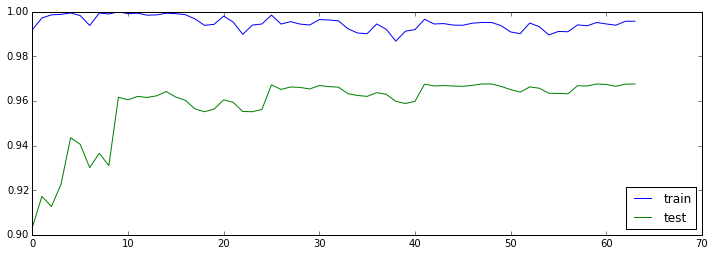

In [40]:
plt.figure(figsize=(12, 4))
plt.plot(chain_train_aucs, label='train')
plt.plot(chain_test_aucs, label='test')
plt.legend(loc='lower right')

In [41]:
chain_xgb_proba = chain_xgb.predict_proba(X_test)[:, 1].astype('float64')

Stacked RF + XGB......... 0.965
Stacked XGB + XGB........ 0.983
XGB...................... 0.985
RF....................... 0.951
chain XGB................ 0.968


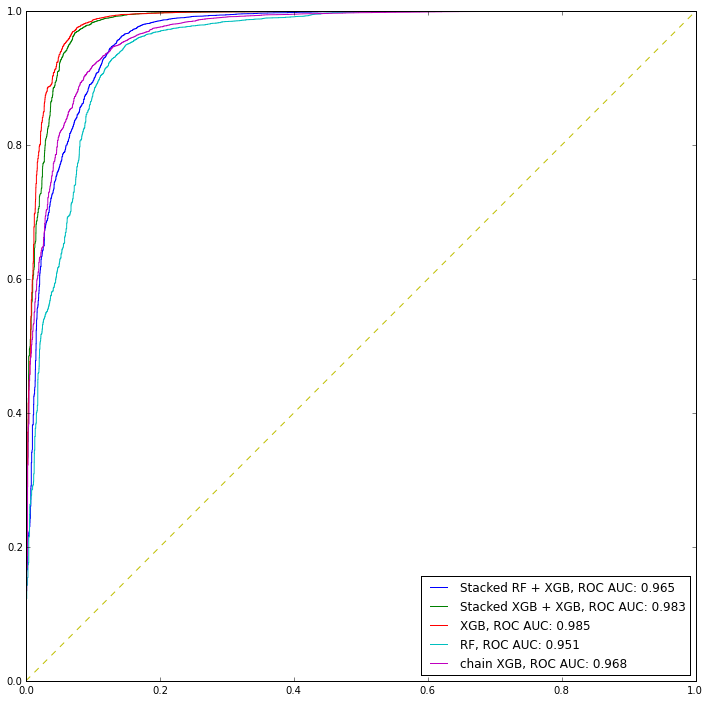

In [42]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 12))

fpr, tpr, _ = roc_curve(y_test, stacked_rf_xgb_proba, sample_weight=w_test)
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, '-', label='%s, ROC AUC: %.3f' % ('Stacked RF + XGB', auc_score))

print 'Stacked RF + XGB'.ljust(25, '.') ,'%.3f' % auc_score

fpr, tpr, _ = roc_curve(y_test, stacked_double_xgb_proba, sample_weight=w_test)
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, '-', label='%s, ROC AUC: %.3f' % ('Stacked XGB + XGB', auc_score))

print 'Stacked XGB + XGB'.ljust(25, '.') ,'%.3f' % auc_score

fpr, tpr, _ = roc_curve(y_test, xgb_proba, sample_weight=w_test)
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, '-', label='%s, ROC AUC: %.3f' % ('XGB', auc_score))

print 'XGB'.ljust(25, '.') ,'%.3f' % auc_score

fpr, tpr, _ = roc_curve(y_test, rf_proba, sample_weight=w_test)
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, '-', label='%s, ROC AUC: %.3f' % ('RF', auc_score))

print 'RF'.ljust(25, '.') ,'%.3f' % auc_score

fpr, tpr, _ = roc_curve(y_test, chain_xgb_proba, sample_weight=w_test)
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, '-', label='%s, ROC AUC: %.3f' % ('chain XGB', auc_score))

print 'chain XGB'.ljust(25, '.') ,'%.3f' % auc_score

plt.plot([0, 1], [0, 1], '--')
plt.legend(loc='lower right')
plt.show()